# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes



config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,                      
    },
    'data': {
        'number_of_variables': 5, 
        'num_classes': 2,
        
        'function_generation_type': 'make_classification_vanilla_decision_tree_trained', # 'make_classification' 'random_decision_tree' 'random_decision_tree_trained' 'random_vanilla_decision_tree_trained' 'make_classification_vanilla_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 1000, #number of samples per function
        'number_of_generated_datasets': 50000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [256],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 50000,
    },     
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500,
    },    
    
    'computation':{
        'n_jobs': -5,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize1000_numLNets50000_var5_class2_make_classification_vanilla_decision_tree_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_fullyGrown/256_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize1000_numDatasets50000_var5_class2_make_classification_vanilla_decision_tree_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [8]:
lambda_network_layers

[256]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)

## Data Inspection

In [10]:
function_df.head()

,f0v0,f0v1,f0v2,f0v3,f0v4,f1v0,f1v1,f1v2,f1v3,f1v4,f2v0,f2v1,f2v2,f2v3,f2v4,f3v0,f3v1,f3v2,f3v3,f3v4,f4v0,f4v1,f4v2,f4v3,f4v4,f5v0,f5v1,f5v2,f5v3,f5v4,f6v0,f6v1,f6v2,f6v3,f6v4,f7v0,f7v1,f7v2,f7v3,f7v4,f8v0,f8v1,f8v2,f8v3,f8v4,f9v0,f9v1,f9v2,f9v3,f9v4,f10v0,f10v1,f10v2,f10v3,f10v4,f11v0,f11v1,f11v2,f11v3,f11v4,f12v0,f12v1,f12v2,f12v3,f12v4,f13v0,f13v1,f13v2,f13v3,f13v4,f14v0,f14v1,f14v2,f14v3,f14v4,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1,lp8c0,lp8c1,lp9c0,lp9c1,lp10c0,lp10c1,lp11c0,lp11c1,lp12c0,lp12c1,lp13c0,lp13c1,lp14c0,lp14c1,lp15c0,lp15c1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
X_data_list[0][0].head(10)

f0v0    0
f0v1    0
f0v2    0
f0v3    0
f0v4    0
f1v0    0
f1v1    0
f1v2    0
f1v3    0
f1v4    0
dtype: int64

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4
0,0.612,0.782,0.543,0.358,0.510
1,0.330,0.651,0.330,0.534,0.460
2,0.467,0.599,0.403,0.600,0.655
3,0.360,0.610,0.510,0.688,0.361
4,0.759,0.396,0.464,0.477,0.674
5,0.552,0.616,0.220,0.453,0.625
6,0.110,0.477,0.161,0.400,0.602
7,0.356,0.627,0.418,0.607,0.597
8,0.371,0.688,0.306,0.452,0.346
9,0.348,0.655,0.488,0.669,0.381


In [13]:
y_data_list[0][0].head(10)

f0v0    0
f0v1    0
f0v2    0
f0v3    0
f0v4    0
f1v0    0
f1v1    0
f1v2    0
f1v3    0
f1v4    0
dtype: int64

In [14]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,0
4,1
5,1
6,1
7,0
8,0
9,0


In [15]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        #y_data[1].reshape(-1, 1)
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [16]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [17]:
y_data_list[0][0].head(10)

f0v0    0
f0v1    0
f0v2    0
f0v3    0
f0v4    0
f1v0    0
f1v1    0
f1v2    0
f1v3    0
f1v4    0
dtype: int64

In [18]:
y_data_list[0][0]

f0v0      0
f0v1      0
f0v2      0
f0v3      0
f0v4      0
         ..
lp13c1    0
lp14c0    0
lp14c1    0
lp15c0    0
lp15c1    0
Length: 122, dtype: int64

In [19]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,0
4,1
5,1
6,1
7,0
8,0
9,0


## Lambda Network Training + Weigh/Bias saving

In [20]:
#%load_ext autoreload

In [21]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

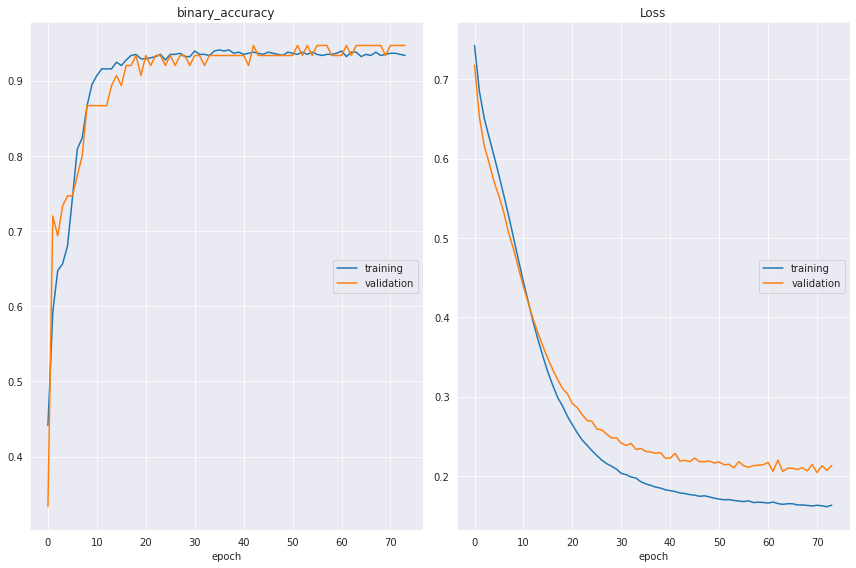

binary_accuracy
	training         	 (min:    0.441, max:    0.941, cur:    0.933)
	validation       	 (min:    0.333, max:    0.947, cur:    0.947)
Loss
	training         	 (min:    0.161, max:    0.743, cur:    0.163)
	validation       	 (min:    0.204, max:    0.718, cur:    0.213)


In [22]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

In [23]:
#%autoreload 2
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data) in enumerate(zip(X_data_list, y_data_list)))  
del parallel

[Parallel(n_jobs=-5)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-5)]: Done  88 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-5)]: Done 248 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-5)]: Done 472 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-5)]: Done 760 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-5)]: Done 1112 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-5)]: Done 1528 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-5)]: Done 2008 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-5)]: Done 2552 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-5)]: Done 3160 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-5)]: Done 3832 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-5)]: Done 4568 tasks      | elapsed: 42.4min
[Parallel(n_jobs=-5)]: Done 5368 tasks      | elapsed: 49.9min
[Parallel(n_jobs=-5)]: Done 6232 tasks      | elapsed: 57.8min
[Parallel(n_jobs=-5)]: Done 7160 tasks      | elapsed: 66.3min
[Parallel(n_jobs=-5)]: Done 8152 tasks      |

In [24]:
random_network['model'].get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 5),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 5),
    'dtype': 'float32',
    'units': 256,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initializ

In [25]:
random_network['model'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________


## Save and Plot Lambda-Model History

In [26]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [27]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [28]:
loss_df.describe()

,index,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,loss_epoch_11,loss_epoch_12,loss_epoch_13,loss_epoch_14,loss_epoch_15,loss_epoch_16,loss_epoch_17,loss_epoch_18,loss_epoch_19,loss_epoch_20,loss_epoch_21,loss_epoch_22,loss_epoch_23,loss_epoch_24,loss_epoch_25,loss_epoch_26,loss_epoch_27,loss_epoch_28,loss_epoch_29,loss_epoch_30,loss_epoch_31,loss_epoch_32,loss_epoch_33,loss_epoch_34,loss_epoch_35,loss_epoch_36,loss_epoch_37,loss_epoch_38,loss_epoch_39,loss_epoch_40,loss_epoch_41,loss_epoch_42,loss_epoch_43,loss_epoch_44,loss_epoch_45,loss_epoch_46,loss_epoch_47,loss_epoch_48,loss_epoch_49,loss_epoch_50,loss_epoch_51,loss_epoch_52,loss_epoch_53,loss_epoch_54,loss_epoch_55,loss_epoch_56,loss_epoch_57,loss_epoch_58,loss_epoch_59,loss_epoch_60,loss_epoch_61,loss_epoch_62,loss_epoch_63,loss_epoch_64,loss_epoch_65,loss_epoch_66,loss_epoch_67,loss_epoch_68,loss_epoch_69,loss_epoch_70,loss_epoch_71,loss_epoch_72,loss_epoch_73,loss_epoch_74,loss_epoch_75,loss_epoch_76,loss_epoch_77,loss_epoch_78,loss_epoch_79,loss_epoch_80,loss_epoch_81,loss_epoch_82,loss_epoch_83,loss_epoch_84,loss_epoch_85,loss_epoch_86,loss_epoch_87,loss_epoch_88,loss_epoch_89,loss_epoch_90,loss_epoch_91,loss_epoch_92,loss_epoch_93,loss_epoch_94,loss_epoch_95,loss_epoch_96,loss_epoch_97,loss_epoch_98,loss_epoch_99,...,loss_epoch_320,loss_epoch_321,loss_epoch_322,loss_epoch_323,loss_epoch_324,loss_epoch_325,loss_epoch_326,loss_epoch_327,loss_epoch_328,loss_epoch_329,loss_epoch_330,loss_epoch_331,loss_epoch_332,loss_epoch_333,loss_epoch_334,loss_epoch_335,loss_epoch_336,loss_epoch_337,loss_epoch_338,loss_epoch_339,loss_epoch_340,loss_epoch_341,loss_epoch_342,loss_epoch_343,loss_epoch_344,loss_epoch_345,loss_epoch_346,loss_epoch_347,loss_epoch_348,loss_epoch_349,loss_epoch_350,loss_epoch_351,loss_epoch_352,loss_epoch_353,loss_epoch_354,loss_epoch_355,loss_epoch_356,loss_epoch_357,loss_epoch_358,loss_epoch_359,loss_epoch_360,loss_epoch_361,loss_epoch_362,loss_epoch_363,loss_epoch_364,loss_epoch_365,loss_epoch_366,loss_epoch_367,loss_epoch_368,loss_epoch_369,loss_epoch_370,loss_epoch_371,loss_epoch_372,loss_epoch_373,loss_epoch_374,loss_epoch_375,loss_epoch_376,loss_epoch_377,loss_epoch_378,loss_epoch_379,loss_epoch_380,loss_epoch_381,loss_epoch_382,loss_epoch_383,loss_epoch_384,loss_epoch_385,loss_epoch_386,loss_epoch_387,loss_epoch_388,loss_epoch_389,loss_epoch_390,loss_epoch_391,loss_epoch_392,loss_epoch_393,loss_epoch_394,loss_epoch_395,loss_epoch_396,loss_epoch_397,loss_epoch_398,loss_epoch_399,loss_epoch_400,loss_epoch_401,loss_epoch_402,loss_epoch_403,loss_epoch_404,loss_epoch_405,loss_epoch_406,loss_epoch_407,loss_epoch_408,loss_epoch_409,loss_epoch_410,loss_epoch_411,loss_epoch_412,loss_epoch_413,loss_epoch_414,loss_epoch_415,loss_epoch_416,loss_epoch_417,loss_epoch_418,loss_epoch_419
count,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,49988.000,49984.000,49982.000,49981.000,49981.000,49977.000,49976.000,49974.000,49973.000,49972.000,49972.000,49965.000,49959.000,49951.000,49936.000,49921.000,49910.000,49881.000,49860.000,49829.000,49804.000,49756.000,49718.000,49652.000,49595.000,49522.000,49436.000,49369.000,49276.000,49169.000,49073.000,48967.000,48833.000,48721.000,48574.000,48422.000,48273.000,48100.000,47926.000,47728.000,47556.000,47348.000,47158.000,46964.000,46735.000,46501.000,46234.000,45957.000,45670.000,45371.000,45076.000,44829.000,44531.000,44259.000,43911.000,43580.000,43237.000,42913.000,42566.000,42199.000,41845.000,41505.000,41104.000,40741.000,40336.000,39970.000,39579.000,39217.000,38847.000,38475.000,38103.000,37730.000,37362.000,37031.000,36666.000,36303.000,35950.000,35593.000,...,58.000,57.000,55.000,51.000,50.000,45.000,42.000,40.000,36.000,36.000,35.000,32.000,31.000,29.000,28.0

In [29]:
val_loss_df.describe()

,index,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,val_loss_epoch_11,val_loss_epoch_12,val_loss_epoch_13,val_loss_epoch_14,val_loss_epoch_15,val_loss_epoch_16,val_loss_epoch_17,val_loss_epoch_18,val_loss_epoch_19,val_loss_epoch_20,val_loss_epoch_21,val_loss_epoch_22,val_loss_epoch_23,val_loss_epoch_24,val_loss_epoch_25,val_loss_epoch_26,val_loss_epoch_27,val_loss_epoch_28,val_loss_epoch_29,val_loss_epoch_30,val_loss_epoch_31,val_loss_epoch_32,val_loss_epoch_33,val_loss_epoch_34,val_loss_epoch_35,val_loss_epoch_36,val_loss_epoch_37,val_loss_epoch_38,val_loss_epoch_39,val_loss_epoch_40,val_loss_epoch_41,val_loss_epoch_42,val_loss_epoch_43,val_loss_epoch_44,val_loss_epoch_45,val_loss_epoch_46,val_loss_epoch_47,val_loss_epoch_48,val_loss_epoch_49,val_loss_epoch_50,val_loss_epoch_51,val_loss_epoch_52,val_loss_epoch_53,val_loss_epoch_54,val_loss_epoch_55,val_loss_epoch_56,val_loss_epoch_57,val_loss_epoch_58,val_loss_epoch_59,val_loss_epoch_60,val_loss_epoch_61,val_loss_epoch_62,val_loss_epoch_63,val_loss_epoch_64,val_loss_epoch_65,val_loss_epoch_66,val_loss_epoch_67,val_loss_epoch_68,val_loss_epoch_69,val_loss_epoch_70,val_loss_epoch_71,val_loss_epoch_72,val_loss_epoch_73,val_loss_epoch_74,val_loss_epoch_75,val_loss_epoch_76,val_loss_epoch_77,val_loss_epoch_78,val_loss_epoch_79,val_loss_epoch_80,val_loss_epoch_81,val_loss_epoch_82,val_loss_epoch_83,val_loss_epoch_84,val_loss_epoch_85,val_loss_epoch_86,val_loss_epoch_87,val_loss_epoch_88,val_loss_epoch_89,val_loss_epoch_90,val_loss_epoch_91,val_loss_epoch_92,val_loss_epoch_93,val_loss_epoch_94,val_loss_epoch_95,val_loss_epoch_96,val_loss_epoch_97,val_loss_epoch_98,val_loss_epoch_99,...,val_loss_epoch_320,val_loss_epoch_321,val_loss_epoch_322,val_loss_epoch_323,val_loss_epoch_324,val_loss_epoch_325,val_loss_epoch_326,val_loss_epoch_327,val_loss_epoch_328,val_loss_epoch_329,val_loss_epoch_330,val_loss_epoch_331,val_loss_epoch_332,val_loss_epoch_333,val_loss_epoch_334,val_loss_epoch_335,val_loss_epoch_336,val_loss_epoch_337,val_loss_epoch_338,val_loss_epoch_339,val_loss_epoch_340,val_loss_epoch_341,val_loss_epoch_342,val_loss_epoch_343,val_loss_epoch_344,val_loss_epoch_345,val_loss_epoch_346,val_loss_epoch_347,val_loss_epoch_348,val_loss_epoch_349,val_loss_epoch_350,val_loss_epoch_351,val_loss_epoch_352,val_loss_epoch_353,val_loss_epoch_354,val_loss_epoch_355,val_loss_epoch_356,val_loss_epoch_357,val_loss_epoch_358,val_loss_epoch_359,val_loss_epoch_360,val_loss_epoch_361,val_loss_epoch_362,val_loss_epoch_363,val_loss_epoch_364,val_loss_epoch_365,val_loss_epoch_366,val_loss_epoch_367,val_loss_epoch_368,val_loss_epoch_369,val_loss_epoch_370,val_loss_epoch_371,val_loss_epoch_372,val_loss_epoch_373,val_loss_epoch_374,val_loss_epoch_375,val_loss_epoch_376,val_loss_epoch_377,val_loss_epoch_378,val_loss_epoch_379,val_loss_epoch_380,val_loss_epoch_381,val_loss_epoch_382,val_loss_epoch_383,val_loss_epoch_384,val_loss_epoch_385,val_loss_epoch_386,val_loss_epoch_387,val_loss_epoch_388,val_loss_epoch_389,val_loss_epoch_390,val_loss_epoch_391,val_loss_epoch_392,val_loss_epoch_393,val_loss_epoch_394,val_loss_epoch_395,val_loss_epoch_396,val_loss_epoch_397,val_loss_epoch_398,val_loss_epoch_399,val_loss_epoch_400,val_loss_epoch_401,val_loss_epoch_402,val_loss_epoch_403,val_loss_epoch_404,val_loss_epoch_405,val_loss_epoch_406,val_loss_epoch_407,val_loss_epoch_408,val_loss_epoch_409,val_loss_epoch_410,val_loss_epoch_411,val_loss_epoch_412,val_loss_epoch_413,val_loss_epoch_414,val_loss_epoch_415,val_loss_epoch_416,val_loss_epoch_417,val_loss_epoch_418,val_loss_epoch_419
count,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,49988.000,49984.000,49982.000,49981.000,49981.000,49977.000,49976.000,49974.000,49973.000,

In [30]:
metric_df.describe()

,index,binary_accuracy_epoch_1,binary_accuracy_epoch_2,binary_accuracy_epoch_3,binary_accuracy_epoch_4,binary_accuracy_epoch_5,binary_accuracy_epoch_6,binary_accuracy_epoch_7,binary_accuracy_epoch_8,binary_accuracy_epoch_9,binary_accuracy_epoch_10,binary_accuracy_epoch_11,binary_accuracy_epoch_12,binary_accuracy_epoch_13,binary_accuracy_epoch_14,binary_accuracy_epoch_15,binary_accuracy_epoch_16,binary_accuracy_epoch_17,binary_accuracy_epoch_18,binary_accuracy_epoch_19,binary_accuracy_epoch_20,binary_accuracy_epoch_21,binary_accuracy_epoch_22,binary_accuracy_epoch_23,binary_accuracy_epoch_24,binary_accuracy_epoch_25,binary_accuracy_epoch_26,binary_accuracy_epoch_27,binary_accuracy_epoch_28,binary_accuracy_epoch_29,binary_accuracy_epoch_30,binary_accuracy_epoch_31,binary_accuracy_epoch_32,binary_accuracy_epoch_33,binary_accuracy_epoch_34,binary_accuracy_epoch_35,binary_accuracy_epoch_36,binary_accuracy_epoch_37,binary_accuracy_epoch_38,binary_accuracy_epoch_39,binary_accuracy_epoch_40,binary_accuracy_epoch_41,binary_accuracy_epoch_42,binary_accuracy_epoch_43,binary_accuracy_epoch_44,binary_accuracy_epoch_45,binary_accuracy_epoch_46,binary_accuracy_epoch_47,binary_accuracy_epoch_48,binary_accuracy_epoch_49,binary_accuracy_epoch_50,binary_accuracy_epoch_51,binary_accuracy_epoch_52,binary_accuracy_epoch_53,binary_accuracy_epoch_54,binary_accuracy_epoch_55,binary_accuracy_epoch_56,binary_accuracy_epoch_57,binary_accuracy_epoch_58,binary_accuracy_epoch_59,binary_accuracy_epoch_60,binary_accuracy_epoch_61,binary_accuracy_epoch_62,binary_accuracy_epoch_63,binary_accuracy_epoch_64,binary_accuracy_epoch_65,binary_accuracy_epoch_66,binary_accuracy_epoch_67,binary_accuracy_epoch_68,binary_accuracy_epoch_69,binary_accuracy_epoch_70,binary_accuracy_epoch_71,binary_accuracy_epoch_72,binary_accuracy_epoch_73,binary_accuracy_epoch_74,binary_accuracy_epoch_75,binary_accuracy_epoch_76,binary_accuracy_epoch_77,binary_accuracy_epoch_78,binary_accuracy_epoch_79,binary_accuracy_epoch_80,binary_accuracy_epoch_81,binary_accuracy_epoch_82,binary_accuracy_epoch_83,binary_accuracy_epoch_84,binary_accuracy_epoch_85,binary_accuracy_epoch_86,binary_accuracy_epoch_87,binary_accuracy_epoch_88,binary_accuracy_epoch_89,binary_accuracy_epoch_90,binary_accuracy_epoch_91,binary_accuracy_epoch_92,binary_accuracy_epoch_93,binary_accuracy_epoch_94,binary_accuracy_epoch_95,binary_accuracy_epoch_96,binary_accuracy_epoch_97,binary_accuracy_epoch_98,binary_accuracy_epoch_99,...,binary_accuracy_epoch_320,binary_accuracy_epoch_321,binary_accuracy_epoch_322,binary_accuracy_epoch_323,binary_accuracy_epoch_324,binary_accuracy_epoch_325,binary_accuracy_epoch_326,binary_accuracy_epoch_327,binary_accuracy_epoch_328,binary_accuracy_epoch_329,binary_accuracy_epoch_330,binary_accuracy_epoch_331,binary_accuracy_epoch_332,binary_accuracy_epoch_333,binary_accuracy_epoch_334,binary_accuracy_epoch_335,binary_accuracy_epoch_336,binary_accuracy_epoch_337,binary_accuracy_epoch_338,binary_accuracy_epoch_339,binary_accuracy_epoch_340,binary_accuracy_epoch_341,binary_accuracy_epoch_342,binary_accuracy_epoch_343,binary_accuracy_epoch_344,binary_accuracy_epoch_345,binary_accuracy_epoch_346,binary_accuracy_epoch_347,binary_accuracy_epoch_348,binary_accuracy_epoch_349,binary_accuracy_epoch_350,binary_accuracy_epoch_351,binary_accuracy_epoch_352,binary_accuracy_epoch_353,binary_accuracy_epoch_354,binary_accuracy_epoch_355,binary_accuracy_epoch_356,binary_accuracy_epoch_357,binary_accuracy_epoch_358,binary_accuracy_epoch_359,binary_accuracy_epoch_360,binary_accuracy_epoch_361,binary_accuracy_epoch_362,binary_accuracy_epoch_363,binary_accuracy_epoch_364,binary_accuracy_epoch_365,binary_accuracy_epoch_366,binary_accuracy_epoch_367,binary_accuracy_epoch_368,binary_accuracy_epoch_369,binary_accuracy_epoch_370,binary_accuracy_epoch_371,binary_accuracy_epoch_372,binary_accuracy_epoch_373,binary_accuracy_epoch_374,binary_accuracy_epoch_375,binary_accuracy_epoch_376,binary_accuracy_epoch_377,binary_accuracy

In [31]:
val_metric_df.describe()

,index,val_binary_accuracy_epoch_1,val_binary_accuracy_epoch_2,val_binary_accuracy_epoch_3,val_binary_accuracy_epoch_4,val_binary_accuracy_epoch_5,val_binary_accuracy_epoch_6,val_binary_accuracy_epoch_7,val_binary_accuracy_epoch_8,val_binary_accuracy_epoch_9,val_binary_accuracy_epoch_10,val_binary_accuracy_epoch_11,val_binary_accuracy_epoch_12,val_binary_accuracy_epoch_13,val_binary_accuracy_epoch_14,val_binary_accuracy_epoch_15,val_binary_accuracy_epoch_16,val_binary_accuracy_epoch_17,val_binary_accuracy_epoch_18,val_binary_accuracy_epoch_19,val_binary_accuracy_epoch_20,val_binary_accuracy_epoch_21,val_binary_accuracy_epoch_22,val_binary_accuracy_epoch_23,val_binary_accuracy_epoch_24,val_binary_accuracy_epoch_25,val_binary_accuracy_epoch_26,val_binary_accuracy_epoch_27,val_binary_accuracy_epoch_28,val_binary_accuracy_epoch_29,val_binary_accuracy_epoch_30,val_binary_accuracy_epoch_31,val_binary_accuracy_epoch_32,val_binary_accuracy_epoch_33,val_binary_accuracy_epoch_34,val_binary_accuracy_epoch_35,val_binary_accuracy_epoch_36,val_binary_accuracy_epoch_37,val_binary_accuracy_epoch_38,val_binary_accuracy_epoch_39,val_binary_accuracy_epoch_40,val_binary_accuracy_epoch_41,val_binary_accuracy_epoch_42,val_binary_accuracy_epoch_43,val_binary_accuracy_epoch_44,val_binary_accuracy_epoch_45,val_binary_accuracy_epoch_46,val_binary_accuracy_epoch_47,val_binary_accuracy_epoch_48,val_binary_accuracy_epoch_49,val_binary_accuracy_epoch_50,val_binary_accuracy_epoch_51,val_binary_accuracy_epoch_52,val_binary_accuracy_epoch_53,val_binary_accuracy_epoch_54,val_binary_accuracy_epoch_55,val_binary_accuracy_epoch_56,val_binary_accuracy_epoch_57,val_binary_accuracy_epoch_58,val_binary_accuracy_epoch_59,val_binary_accuracy_epoch_60,val_binary_accuracy_epoch_61,val_binary_accuracy_epoch_62,val_binary_accuracy_epoch_63,val_binary_accuracy_epoch_64,val_binary_accuracy_epoch_65,val_binary_accuracy_epoch_66,val_binary_accuracy_epoch_67,val_binary_accuracy_epoch_68,val_binary_accuracy_epoch_69,val_binary_accuracy_epoch_70,val_binary_accuracy_epoch_71,val_binary_accuracy_epoch_72,val_binary_accuracy_epoch_73,val_binary_accuracy_epoch_74,val_binary_accuracy_epoch_75,val_binary_accuracy_epoch_76,val_binary_accuracy_epoch_77,val_binary_accuracy_epoch_78,val_binary_accuracy_epoch_79,val_binary_accuracy_epoch_80,val_binary_accuracy_epoch_81,val_binary_accuracy_epoch_82,val_binary_accuracy_epoch_83,val_binary_accuracy_epoch_84,val_binary_accuracy_epoch_85,val_binary_accuracy_epoch_86,val_binary_accuracy_epoch_87,val_binary_accuracy_epoch_88,val_binary_accuracy_epoch_89,val_binary_accuracy_epoch_90,val_binary_accuracy_epoch_91,val_binary_accuracy_epoch_92,val_binary_accuracy_epoch_93,val_binary_accuracy_epoch_94,val_binary_accuracy_epoch_95,val_binary_accuracy_epoch_96,val_binary_accuracy_epoch_97,val_binary_accuracy_epoch_98,val_binary_accuracy_epoch_99,...,val_binary_accuracy_epoch_320,val_binary_accuracy_epoch_321,val_binary_accuracy_epoch_322,val_binary_accuracy_epoch_323,val_binary_accuracy_epoch_324,val_binary_accuracy_epoch_325,val_binary_accuracy_epoch_326,val_binary_accuracy_epoch_327,val_binary_accuracy_epoch_328,val_binary_accuracy_epoch_329,val_binary_accuracy_epoch_330,val_binary_accuracy_epoch_331,val_binary_accuracy_epoch_332,val_binary_accuracy_epoch_333,val_binary_accuracy_epoch_334,val_binary_accuracy_epoch_335,val_binary_accuracy_epoch_336,val_binary_accuracy_epoch_337,val_binary_accuracy_epoch_338,val_binary_accuracy_epoch_339,val_binary_accuracy_epoch_340,val_binary_accuracy_epoch_341,val_binary_accuracy_epoch_342,val_binary_accuracy_epoch_343,val_binary_accuracy_epoch_344,val_binary_accuracy_epoch_345,val_binary_accuracy_epoch_346,val_binary_accuracy_epoch_347,val_binary_accuracy_epoch_348,val_binary_accuracy_epoch_349,val_binary_accuracy_epoch_350,val_binary_accuracy_epoch_351,val_binary_accuracy_epoch_352,val_binary_accuracy_epoch_353,val_binary_accuracy_epoch_354,val_binary_accuracy_epoch_355,val_binary_accuracy_epoch_356,val_binary_accura

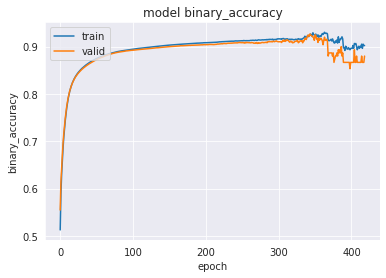

In [32]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


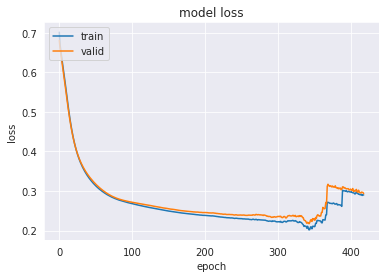

In [33]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()
